# Can ATOTI Predict Baseball? How will the COVID Season Impact Baseball Stats?

Baseball is a game built on statistics.  There seems to be a statistic for every possible combination and permutation of events that can happen in a game or a  season.  Fans enjoy comparing stats in a perpetual game of "who was the greatest (<i>fill in the blank</i>); creating matchups that span generations.  The availability of data analysis tool like ATOTI bring a whole new dimension (no pun intended) to these discussons allowing for endless analysis which <b><u> WARNING</u></b> can become addictive :-).

For a game that loves its statistics, the 2020 Covid shortened season presents a nightmare.  Instead of playing 162 games the season will only be 60, setting up no doubt endless "what if" debates in future years in regards to players active in this season who just miss key milestones.

In this notebook, we decide to get a jump on the debate by looking at veterans who have diminishing season to make up those lost 102 games, focusing in on a specific example.


## The Data

The dataset used comes from Sean Lahman's website at http://www.seanlahman.com/baseball-archive/statistics/. The work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. This is a great site and has more types of Baseball stats starting from 1871 than you can imageine.  For the purpose of this exercise we will confine ourselve to Batting Statistics

We will first start by importing support libraries and atoti creating an atoti session.

In [1]:
import atoti as tt #Get Atoti
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra


Welcome to atoti 0.4.1!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Importing The Data and Wrangeling 

The dataset used comes from Sean Lahman's website at http://www.seanlahman.com/baseball-archive/statistics/. The work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. This is a great site and has more types of Baseball stats than you can imagine.  For the purpose of this exercise we will confine ourselve to Batting Statistics. For those more interested in the analaysis, you can skip to the <i> Create the ATOTI Cube</i> section

We begin by importing the master table which has individual player information 

In [2]:
pd.set_option('display.max_columns', None) 
#dM=pd.read_csv('C:/Users/ncosgrov/DataSets/Baseball/2019/baseballdatabank-master/core/people.csv', usecols = ['playerID','birthYear','nameGiven','nameLast','nameFirst','bats','throws','debut','finalGame']) 
dM=pd.read_csv('./BaseballData/people.csv', usecols = ['playerID','birthYear','nameGiven','nameLast','nameFirst','bats','throws','debut','finalGame'])  

In [3]:
dM.head()

,playerID,birthYear,nameFirst,nameLast,nameGiven,bats,throws,debut,finalGame
0,aardsda01,1981.0,David,Aardsma,David Allan,R,R,2004-04-06,2015-08-23
1,aaronha01,1934.0,Hank,Aaron,Henry Louis,R,R,1954-04-13,1976-10-03
2,aaronto01,1939.0,Tommie,Aaron,Tommie Lee,R,R,1962-04-10,1971-09-26
3,aasedo01,1954.0,Don,Aase,Donald William,R,R,1977-07-26,1990-10-03
4,abadan01,1972.0,Andy,Abad,Fausto Andres,L,L,2001-09-10,2006-04-13


In [4]:
dM.shape

(19878, 9)

In [5]:
dM.dtypes

playerID      object
birthYear    float64
nameFirst     object
nameLast      object
nameGiven     object
bats          object
throws        object
debut         object
finalGame     object
dtype: object

We will do some data cleanup.  The dataset has a lot of early 19th century data that is missing values (not the datasets fault, just no one recorded the values at the time).

In [6]:
#Lets Clean up names
#Get Rid of Blank First and Given Names, records where we dont know when player started
dM.dropna(subset=['nameFirst','debut'], inplace=True)
dM['nameGiven'].fillna('Unknown',inplace = True)

In [7]:
FullName=dM['nameFirst']+' '+dM['nameLast']
dM.insert(4,'FullName',FullName)

In [8]:
dM.head()

,playerID,birthYear,nameFirst,nameLast,FullName,nameGiven,bats,throws,debut,finalGame
0,aardsda01,1981.0,David,Aardsma,David Aardsma,David Allan,R,R,2004-04-06,2015-08-23
1,aaronha01,1934.0,Hank,Aaron,Hank Aaron,Henry Louis,R,R,1954-04-13,1976-10-03
2,aaronto01,1939.0,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-04-10,1971-09-26
3,aasedo01,1954.0,Don,Aase,Don Aase,Donald William,R,R,1977-07-26,1990-10-03
4,abadan01,1972.0,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-09-10,2006-04-13


In [9]:
dM['birthYear'] = dM['birthYear'].astype('Int64')

In [10]:
dM.head()

,playerID,birthYear,nameFirst,nameLast,FullName,nameGiven,bats,throws,debut,finalGame
0,aardsda01,1981,David,Aardsma,David Aardsma,David Allan,R,R,2004-04-06,2015-08-23
1,aaronha01,1934,Hank,Aaron,Hank Aaron,Henry Louis,R,R,1954-04-13,1976-10-03
2,aaronto01,1939,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-04-10,1971-09-26
3,aasedo01,1954,Don,Aase,Don Aase,Donald William,R,R,1977-07-26,1990-10-03
4,abadan01,1972,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-09-10,2006-04-13


Anticipating that in future analysis we may want to do some analysis where we compare players on "career years" rather than "calendar years" we create a dictionary of the years players debuted for use in the next table.

In [11]:
TempDict=dM.groupby('playerID')['debut'].apply(list).to_dict()
DebutDict={}
for key in TempDict:
    date=TempDict[key]
    y=date[0]
    if isinstance(y, str):
        y=y[0:4]
        DebutDict[key] =int(y)

OK, the Master table of player info is done, lets import the batting table and clean it up

In [12]:
dB=pd.read_csv('./BaseballData/Batting.csv')

In [13]:
dB.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [14]:
dB.shape

(107429, 22)

In [15]:
dB.lgID.unique()

array([nan, 'NL', 'AA', 'UA', 'PL', 'AL', 'FL'], dtype=object)

In [16]:
# Cull down to just NL and Al Leagues
NonModernLeagueNames =['AA', 'UA', 'PL','FL','nan']
indexNames = dB[dB['lgID'].isin(NonModernLeagueNames)].index
dB.drop(indexNames , inplace=True)
dB.lgID.unique()

array([nan, 'NL', 'AL'], dtype=object)

create a Key column

In [17]:
dB.insert(loc=0, column='pkey', value=1+np.arange(len(dB)))
dB.set_index('pkey')
dB.head()

,pkey,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,1,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,2,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,3,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,4,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,5,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [18]:
dB.dtypes

pkey          int32
playerID     object
yearID        int64
stint         int64
teamID       object
lgID         object
G             int64
AB            int64
R             int64
H             int64
2B            int64
3B            int64
HR            int64
RBI         float64
SB          float64
CS          float64
BB            int64
SO          float64
IBB         float64
HBP         float64
SH          float64
SF          float64
GIDP        float64
dtype: object

In [19]:
convert_dict = {
                'yearID':str, 
                'lgID':str,
                'RBI':'Int64',
                'SB':'Int64',
                'CS':'Int64',
                'SO':'Int64',
                'IBB':'Int64',
                'HBP':'Int64',
                'SH':'Int64',
                'SF':'Int64',
                'GIDP':'Int64'
               } 
  
dB = dB.astype(convert_dict) 

Team ID is deceptive, it is not as "human readable" as you would think, lets replace with franchise names (but note that these will be the current franchise name, i.e. Babe Ruth's Boston Braves will show that the team is currently the Atlanta Braves)

Get Franchises and create a dictionary of Franchise ID to name 

In [20]:
dF=pd.read_csv('./BaseballData/TeamsFranchises.csv')

In [21]:
dF.head()

,franchID,franchName,active,NAassoc
0,ALT,Altoona Mountain City,N,NaN
1,ANA,Los Angeles Angels of Anaheim,Y,NaN
2,ARI,Arizona Diamondbacks,Y,NaN
3,ATH,Philadelphia Athletics,N,PNA
4,ATL,Atlanta Braves,Y,BNA


In [22]:
dictFranchiseToName=pd.Series(dF.franchName.values,index=dF.franchID).to_dict()

Create a dictionary of teamid  franchid

In [23]:
dT=pd.read_csv('./BaseballData/Teams.csv')

In [24]:
dT.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,NaN,NaN,N,NaN,401,1372,426,70,37,3,60.0,19.0,73.0,16.0,NaN,NaN,303,109,3.55,22,1,3,828,367,2,42,23,243,24,0.834,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,NaN,NaN,N,NaN,302,1196,323,52,21,10,60.0,22.0,69.0,21.0,NaN,NaN,241,77,2.76,25,0,1,753,308,6,28,22,229,16,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,NaN,NaN,N,NaN,249,1186,328,35,40,7,26.0,25.0,18.0,8.0,NaN,NaN,341,116,4.11,23,0,0,762,346,13,53,34,234,15,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,NaN,NaN,N,NaN,137,746,178,19,8,2,33.0,9.0,16.0,4.0,NaN,NaN,243,97,5.17,19,1,0,507,261,5,21,17,163,8,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,NaN,NaN,N,NaN,302,1404,403,43,21,1,33.0,15.0,46.0,15.0,NaN,NaN,313,121,3.72,32,1,0,879,373,7,42,22,235,14,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [25]:
dictTeamIDToFranchise=pd.Series(dT.franchID.values,index=dT.teamID).to_dict()

now create a distionary of teamID to Franchise Name

In [26]:
dTeamName={}
for key in dictTeamIDToFranchise.keys():
  tkey=dictTeamIDToFranchise[key]  
  dTeamName[key] = dictFranchiseToName[tkey]

Finally add the team Name

In [27]:
dB["teamName"]=dB['teamID'].map(dTeamName)
dB.head()

,pkey,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,teamName
0,1,abercda01,1871,1,TRO,nan,1,4,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,0,Troy Haymakers
1,2,addybo01,1871,1,RC1,nan,25,118,30,32,6,0,0,13,8,1,4,0,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys
2,3,allisar01,1871,1,CL1,nan,29,137,28,40,4,5,0,19,3,1,2,5,<NA>,<NA>,<NA>,<NA>,1,Cleveland Forest Citys
3,4,allisdo01,1871,1,WS3,nan,27,133,28,44,10,2,2,27,1,1,0,2,<NA>,<NA>,<NA>,<NA>,0,Washington Olympics
4,5,ansonca01,1871,1,RC1,nan,25,120,29,39,11,3,0,16,6,2,2,1,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys


Add Career Season 

In [28]:
dB['CareerYear']=dB['playerID'].map(DebutDict)

In [29]:
dB.head()

,pkey,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,teamName,CareerYear
0,1,abercda01,1871,1,TRO,nan,1,4,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,0,Troy Haymakers,1871.0
1,2,addybo01,1871,1,RC1,nan,25,118,30,32,6,0,0,13,8,1,4,0,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys,1871.0
2,3,allisar01,1871,1,CL1,nan,29,137,28,40,4,5,0,19,3,1,2,5,<NA>,<NA>,<NA>,<NA>,1,Cleveland Forest Citys,1871.0
3,4,allisdo01,1871,1,WS3,nan,27,133,28,44,10,2,2,27,1,1,0,2,<NA>,<NA>,<NA>,<NA>,0,Washington Olympics,1871.0
4,5,ansonca01,1871,1,RC1,nan,25,120,29,39,11,3,0,16,6,2,2,1,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys,1871.0


In [30]:
dB['yearID']=dB['yearID'].astype(int)
dB.dropna(subset=['CareerYear'],inplace=True)
dB['CareerYear']=dB['CareerYear'].astype(int)
dB.head()

,pkey,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,teamName,CareerYear
0,1,abercda01,1871,1,TRO,nan,1,4,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,0,Troy Haymakers,1871
1,2,addybo01,1871,1,RC1,nan,25,118,30,32,6,0,0,13,8,1,4,0,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys,1871
2,3,allisar01,1871,1,CL1,nan,29,137,28,40,4,5,0,19,3,1,2,5,<NA>,<NA>,<NA>,<NA>,1,Cleveland Forest Citys,1871
3,4,allisdo01,1871,1,WS3,nan,27,133,28,44,10,2,2,27,1,1,0,2,<NA>,<NA>,<NA>,<NA>,0,Washington Olympics,1871
4,5,ansonca01,1871,1,RC1,nan,25,120,29,39,11,3,0,16,6,2,2,1,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys,1871


In [31]:
dB['CareerYear'] = (dB['yearID'] - dB['CareerYear']+1)
dB.head()

,pkey,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,teamName,CareerYear
0,1,abercda01,1871,1,TRO,nan,1,4,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,0,Troy Haymakers,1
1,2,addybo01,1871,1,RC1,nan,25,118,30,32,6,0,0,13,8,1,4,0,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys,1
2,3,allisar01,1871,1,CL1,nan,29,137,28,40,4,5,0,19,3,1,2,5,<NA>,<NA>,<NA>,<NA>,1,Cleveland Forest Citys,1
3,4,allisdo01,1871,1,WS3,nan,27,133,28,44,10,2,2,27,1,1,0,2,<NA>,<NA>,<NA>,<NA>,0,Washington Olympics,1
4,5,ansonca01,1871,1,RC1,nan,25,120,29,39,11,3,0,16,6,2,2,1,<NA>,<NA>,<NA>,<NA>,0,Rockford Forest Citys,1


## Create the ATOTI Cube

In [32]:
# Create an Atoti Session.
session = tt.create_session()
session.load_all_data()

# Load the Pandas DataFrames.

Player_Store = session.read_pandas(
    dM,
    # These are the DataFrame's columns that make each row unique
    keys=["playerID"],
    store_name="players"
)
Batting_Store= session.read_pandas(
    dB, keys=["pkey"], store_name="batting"
)

# Join the two stores together.

Batting_Store.join(Player_Store, mapping={"playerID":"playerID"})


In [33]:
print('Number of results: ',Player_Store.shape)

Number of results:  {'rows': 19646, 'columns': 10}


In [34]:
cube = session.create_cube(Batting_Store,name="Stats",mode="manual") 
l = cube.levels
m = cube.measures
h = cube.hierarchies

In [35]:
cube.hierarchies["Year"] = [Batting_Store["yearID"]]
cube.hierarchies["Career Year"] = [Batting_Store["CareerYear"]]
cube.hierarchies["Player"] = [
                                Player_Store["playerID"],
                                Player_Store["FullName"]
                             ]
cube.hierarchies["Team"] = [Batting_Store["teamName"]]

# Lets Review the hierarchies
h

Hierarchies()

Lets see what the stores look like

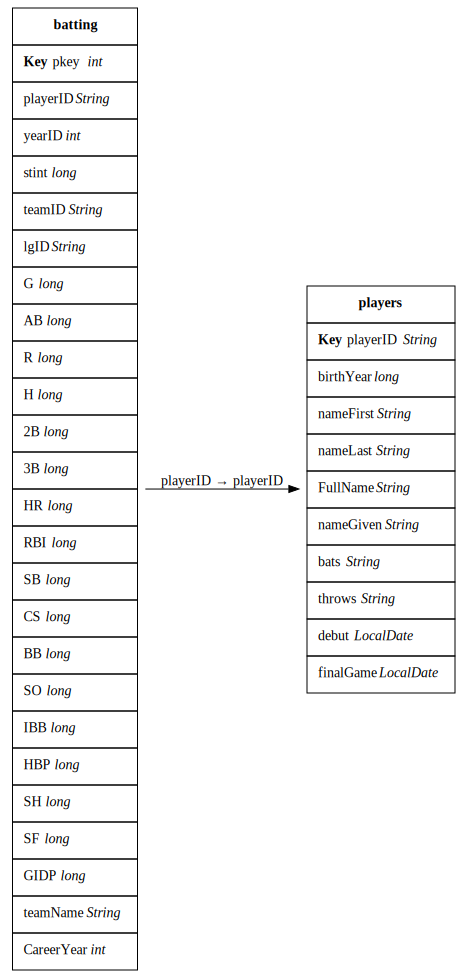

In [36]:
cube.schema

Let us create some measures

In [37]:
m["Games"]=tt.agg.sum(Batting_Store["G"])
m["Latest Season"]=tt.agg.max(Batting_Store["yearID"])
m["Career Length"] =tt.date_diff(Player_Store["debut"],Player_Store["finalGame"], unit='years')
m["BirthYear"]=tt.agg.single_value(Player_Store["birthYear"])
 
m["PlayerAge"]=m["Latest Season"]-m["BirthYear"]

 
m["HR"] = tt.agg.sum(Batting_Store["HR"])
m["PlayerTotalHRYear"] = tt.agg.sum(m["HR"], scope=tt.scope.cumulative(l["yearID"])) 


 
m["Hits"] = tt.agg.sum(Batting_Store["H"])
m["PlayerTotalHitsYear"] = tt.agg.sum(m["Hits"], scope=tt.scope.cumulative(l["yearID"])) 


m["Homeruns Per Game"]=m["HR"]/m["Games"]
m["Hits Per Game"]=m["Hits"]/m["Games"]

 
m["CareerHR"] = tt.agg.sum(m["HR"], scope=tt.scope.cumulative(l["CareerYear"]))   
m["CareerHits"] = tt.agg.sum(m["Hits"], scope=tt.scope.cumulative(l["CareerYear"])) 

m["500 Home Runs"] = 500
m["2020 Season Length"] =60

m["MedianHR"]=tt.agg.mean(m["Homeruns Per Game"], scope=tt.scope.origin(l["playerID"]))
m["Projected HR"]= tt.round(m["2020 Season Length"]*m["MedianHR"])
m["Projected End Of Season Career HRs"]=m["PlayerTotalHRYear"] +m["Projected HR"]

m["MedianHits"]=tt.agg.mean(m["Hits Per Game"], scope=tt.scope.origin(l["playerID"]))
m["Projected Hits"]= tt.round(tt.round(m["2020 Season Length"]*m["MedianHits"]))
m["Projected End Of Season Career Hits"]=m["PlayerTotalHitsYear"] +m["Projected Hits"]

In [38]:
SeasonAtBats =tt.agg.single_value(Batting_Store["AB"])
m["PlayerSeasonAtBats"] =tt.agg.single_value(SeasonAtBats, scope=tt.scope.origin(l["playerID"]))

In [39]:
cube


## The Fun Stuff, the Analysis

So let's pose a basic question: who is being impacted by the COVID shortened Baseball season of 60 rather than 162 games?  Well, certainly everyone as a missed game is an opportunity to put something in the book for the future and even a non-Hall of Famer would like to get one more hit or one more homerun in their career.  However, certainly veteran players, which we will define as 10 years in the league, have less of a career remainder left to make up for lost 2020 opportunities

Sp lets look at players who have played over 10 years and are closing in on the respected 500 Home Run Mark 

In [41]:
cube.visualize("Players over 10 Years in League with over 200 Homer Runs")

Install and enable the atoti JupyterLab extension to see this widget.

Put's into perspective how tough getting 500 Home Runs is.  Pujol is already well past the post, Miguel Cabera is in striking distance at 477. Nelson Cruz (age 40) and Edwin Encarnación (age 37)  have a steep climb to get there and certainly losing 60% of their potential at bats this year  may put it out of reach.

Let us now look at hits, focusing in on the mythical 3000 mark

In [42]:
cube.visualize("Players over 10 Years in League with in top 25% of Career Hits")

Install and enable the atoti JupyterLab extension to see this widget.

Suzuki has retired (he shows as his last game was last year), Pujol it in.  Cano at age 38 and 430 hits outs was facing a tough challenge.  Looking at his career hit production which is declining, the shortened 2020 season may have put is out of reach. The fact that his hit production and games played crossed last season is not a good sign.

In [44]:
cube.visualize("Robinson Cano Hit Production VS Career Years")

Install and enable the atoti JupyterLab extension to see this widget.

However, the most interesting is Miguel Cabera, looking at his 2019 State

In [46]:
cube.visualize("Cabera End of 2019 Stats")

Install and enable the atoti JupyterLab extension to see this widget.

Cabera is well within striking distance to joing  some excluive company the "500 HR/3000 hits club"! A feat attained by only 6 players in the history of Baseball.

In [48]:
cube.visualize("500 HR/3000 hits club")

Install and enable the atoti JupyterLab extension to see this widget.

Let's run a simulation to see what the impact of the shortened 2020 season would be assuming that Cabera "plays to the back of his baseball card" defined as he attains his median hits and home rune per game for the season.  The base will be the now accpted 60 games season versus a standard 162 game season

In [49]:
Season_simulation = cube.setup_simulation(
    "Impact 2020 Season Length Simulation",
    replace=[m["2020 Season Length"]],
    base_scenario="2020 60 Game Season",
)

In [50]:
Season_simulation.scenarios["Full Length 2020"] = 162

<h3>What do Cabera's projected Numbers look like in the 60 game COVID season versus a normal 162 Game Season?</h3>

In [52]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

So per the assumptions of this analysis, if 2020 was a full season,  having a "median year" Cabera would not get him into the "500 HR/3000 hits club", but  he would be <u>very close</u>.  It would certainly not be outside the realm of possibility that if he had a better than average year he could find an extra 19 hits and 9 homeruns over the course of 162 games.  Even if he missed in 2020, getting those landmarks would seem very likely even if Cabera had an off year in 2021.

The concern is that coming out of the shortened season, what would Cabera's numbers look like if after a "median" full 162 game season followed a "median" Covid Shortened season?  Lets run another simulation, where we project a 60 game season followed by a 162 game season. 

In [53]:
Season_simulation.scenarios["Covid Season followed by Full Length 2021"] = 60+162

In [55]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

So the COVID shortened Season turns Miguel Cabera's highly likely induction into the "500 HR/3000 hits club" by the 2021 season under normal circumstanse into a far risky proposition, changing it from an opptomistic "one season away" to a potential "three seasons away" with all the risks that playning an additional three late career seasons entails.

We will have to see the results and if ATOTI disproves that "<i>You can’t predict baseball Suzyn</i>"